In [34]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import datetime
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [9]:
df_prepared_data = pd.read_csv('merged_with_isw.csv', sep=",")

## Split data Train/Test

In [10]:
X = df_prepared_data.drop(columns=['was_alarm'])
y_reg = df_prepared_data['was_alarm']
y_bin = df_prepared_data['was_alarm']

tscv = TimeSeriesSplit(n_splits=5)

## Trainig

In [11]:
df_prepared_data['hour'] = pd.to_datetime(df_prepared_data['hour_datetimeEpoch'], unit='s').dt.hour
df_prepared_data = df_prepared_data.drop(columns=['hour_datetimeEpoch'])
df_prepared_data = pd.get_dummies(df_prepared_data, columns=['region_id'], drop_first=True)

In [12]:
region_ids = list(range(2, 27))

region_map = {
    1: "Simferopol",
    2: "Vinnytsia",
    3: "Lutsk",
    4: "Dnipro",
    5: "Donetsk",
    6: "Zhytomyr",
    7: "Uzhgorod",
    8: "Zaporozhye",
    9: "Ivano-Frankivsk",
    10: "Kyiv_obl",
    11: "Kropyvnytskyi",
    12: "Luhansk",
    13: "Lviv",
    14: "Mykolaiv",
    15: "Odesa",
    16: "Poltava",
    17: "Rivne",
    18: "Sumy",
    19: "Ternopil",
    20: "Kharkiv",
    21: "Kherson",
    22: "Khmelnytskyi",
    23: "Cherkasy",
    24: "Chernivtsi",
    25: "Chernihiv",
    26: "Kyiv"
}

def prepare_region(pred_df):
    pred_df = pd.get_dummies(pred_df, columns=['region_id'], drop_first=False)
    
    pred_df = pred_df.rename(columns={
        f"region_id_{i}": region_map[i]
        for i in region_map
        if f"region_id_{i}" in pred_df.columns
    })
    
    if "Simferopol" in pred_df.columns:
        pred_df = pred_df.drop(columns=["Simferopol"])
    
    expected_columns = [region_map[i] for i in range(2, 27)]
    for col in expected_columns:
        if col not in pred_df.columns:
            pred_df[col] = False
    
    return pred_df[expected_columns]

In [13]:
#p = prepare_region(df_prepared_data)
#df_prepared_data = pd.concat([df_prepared_data, p], axis=1)

KeyError: "None of [Index(['region_id'], dtype='object')] are in the [columns]"

In [14]:
X = df_prepared_data.drop(columns=['was_alarm'])
y = df_prepared_data['was_alarm']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [15]:
df_prepared_data.columns

Index(['date', 'advanc near', 'air defens', 'air forc', 'allow russian',
       'alongsid static', 'area russian', 'arm armi', 'arm forc',
       'armor vehicl',
       ...
       'region_id_17', 'region_id_18', 'region_id_19', 'region_id_20',
       'region_id_21', 'region_id_22', 'region_id_23', 'region_id_24',
       'region_id_25', 'region_id_26'],
      dtype='object', length=255)

In [16]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)


<class 'pandas.core.frame.DataFrame'> (519370, 254)
<class 'pandas.core.series.Series'> (519370,)


In [17]:
print("NaNs in X_train:", X_train.isnull().sum().sum() if hasattr(X_train, "isnull") else np.isnan(X_train).sum())
print("NaNs in y_train:", y_train.isnull().sum() if hasattr(y_train, "isnull") else np.isnan(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0


In [18]:
print(X_train.dtypes.value_counts())


float64    226
bool        23
object       3
int64        1
int32        1
Name: count, dtype: int64


In [19]:
print(set(y_train)) 


{0, 1}


In [20]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print(non_numeric_cols.tolist())


['date', 'day_datetime', 'hour_datetime']


In [21]:
for col in non_numeric_cols:
    print(f"\nColumn: {col}")
    print(X_train[col].unique()[:10])



Column: date
['2022-04-05' '2024-06-08' '2024-10-18' '2025-01-20' '2025-01-05'
 '2024-06-01' '2022-06-30' '2024-01-03' '2024-04-27' '2024-04-25']

Column: day_datetime
['2022-04-05' '2024-06-08' '2024-10-18' '2025-01-20' '2025-01-05'
 '2024-06-01' '2022-06-30' '2024-01-03' '2024-04-27' '2024-04-25']

Column: hour_datetime
['06:00:00' '05:00:00' '22:00:00' '17:00:00' '19:00:00' '10:00:00'
 '07:00:00' '20:00:00' '08:00:00' '14:00:00']


In [22]:
X_train = X_train.drop(columns=['day_datetime'])  


In [23]:
X_train['hour'] = pd.to_datetime(X_train['hour_datetime'], format='%H:%M:%S').dt.hour
X_train = X_train.drop(columns=['hour_datetime'])  


In [24]:

print(X_train.dtypes.value_counts())




float64    226
bool        23
object       1
int64        1
int32        1
Name: count, dtype: int64


In [25]:
X_train.select_dtypes(include='object').columns.tolist()


['date']

In [26]:
X_test = X_test.drop(columns=['date'])


In [27]:
X_train = X_train.drop(columns=['date'])


In [28]:
X_test = X_test.drop(columns=['day_datetime', 'hour_datetime', 'date'], errors='ignore')


In [29]:
class TrainedModel:
    def __init__(self, model):
        self.model = model
        self.trained_at = datetime.datetime.now()
        self.last_predicted_at = None

    def predict(self, X):
        self.last_predicted_at = datetime.datetime.now()
        return self.model.predict(X)

    def get_metadata(self):
        return {
            "trained_at": self.trained_at,
            "last_predicted_at": self.last_predicted_at
        }

In [30]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

trained_model = TrainedModel(clf)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     94576
           1       1.00      0.98      0.99     35267

    accuracy                           1.00    129843
   macro avg       1.00      0.99      0.99    129843
weighted avg       1.00      1.00      1.00    129843



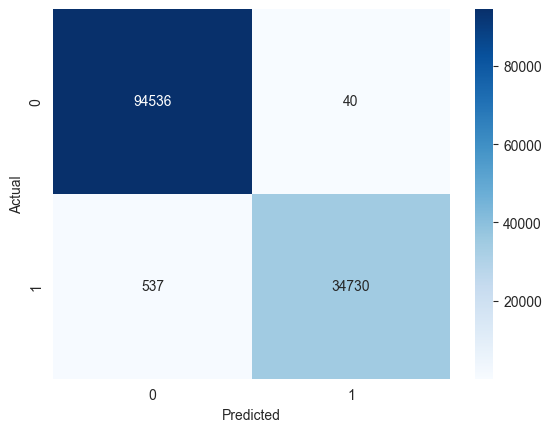

In [59]:

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Axes: xlabel='hour_cloudcover', ylabel='Count'>

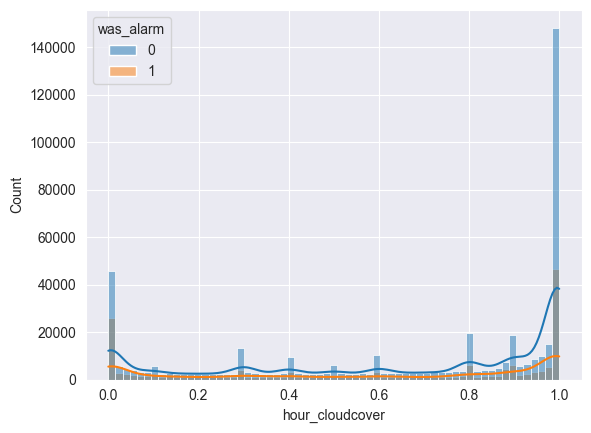

In [61]:
import seaborn as sns
sns.histplot(data=df_prepared_data, x='hour_cloudcover', hue='was_alarm', kde=True)


## Balanced classes

In [38]:
print("До балансування:", Counter(y_train))


До балансування: Counter({0: 378301, 1: 141069})


In [39]:
majority_class = y_train.value_counts().idxmax()
minority_class = y_train.value_counts().idxmin()

n_minority = y_train.value_counts()[minority_class]
n_majority_target = n_minority * 2


rus = RandomUnderSampler(
    sampling_strategy={majority_class: n_majority_target, minority_class: n_minority},
    random_state=42
)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Після балансування:", Counter(y_resampled))


Після балансування: Counter({0: 282138, 1: 141069})


In [40]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94576
           1       0.99      0.99      0.99     35267

    accuracy                           1.00    129843
   macro avg       1.00      0.99      0.99    129843
weighted avg       1.00      1.00      1.00    129843



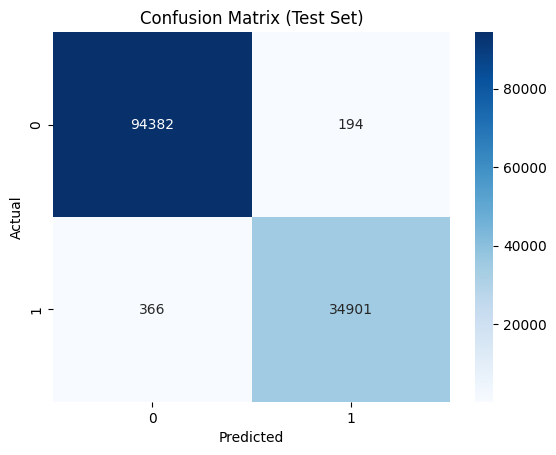

In [41]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()
